# In The Mood For Love

Projeto inspirado pelo filme In The Mood For Love do diretor Wong Kar-Wai. 

In [ ]:
# 1. Fazer um pre processamento logo depois da detecção de cenas 
# Excluir cenas com menos de 1 segundo e mais de 20 segundos, por exemplo 
# Ou excluir cenas com menos de 4 e mais de 12 segundos 
# Utilizar essas cenas para a clusterização e montagem do edit/highlight --OK-- 

# 2. Utilizar somente os valors de R, G e B e achar 3 clusters. Fazer montagem. 

# 3. Achar momento do início e final do filme sem os creditos para não detectar cenas nesses momentos 

# 4. Padronizar documentação e comentários em funções 

# 5. Salvar gráfico de imagem em /figures/ --OK-- 

# 6. Corrigir path de vez no projeto --OK-- 

# 7. Ideia: pegar as cenas com meiores valores de vermelho e fazer edit com essas 

In [165]:
import pandas as pd 
import numpy as np 

import os
from pathlib import Path

# Força CWD para o diretório raiz do projeto (assumindo que notebook está em notebooks/)
ROOT = Path(__file__).resolve().parent.parent if '__file__' in globals() else Path().resolve().parent
os.chdir(ROOT)
print(f"Working directory set to: {ROOT}")

Working directory set to: /home/rafa/Documents/projects/git


In [166]:
from importlib import reload
import sys
sys.path.append('../src')

import utils 
import scene_detection
import feature_extraction 
import visualization
import clustering 
import save_video

reload(utils)
reload(scene_detection)
reload(feature_extraction)
reload(visualization)
reload(clustering)
reload(save_video)

from utils import get_video_info, cut_scenes, from_root
from scene_detection import detect_scene_low_resolution
from feature_extraction import audio_features, extract_frames, image_features, movement_features
from visualization import plot_rms_silence, plot_color_features, plot_movement, plot_cluster_timeline, plot_scatter_umap, plot_scatter_pca
from clustering import clustering 
from save_video import write_top2_cluster_videos

In [ ]:
video_name = 'long' # snippet, long, fullMovie 
file_extension = '.mp4' 
video_file =  video_name + file_extension 

print(get_video_info(video_file)) 

df = pd.DataFrame() 
df = detect_scene_low_resolution(video_file) 

VideoManager is deprecated and will be removed.


Total de shots: 62


In [ ]:
df_cut = cut_scenes(df, 1, 4)
df = df_cut

20

In [ ]:
# Audio features: rms_mean and silence_ratio 
# df = audio_features(video_file, df) 

# Image features: HSV (hue, saturation, value) and RGB (red, green, blue) mean and variation 
df = extract_frames(video_file, df) 
df = image_features(df) 

# df = movement_features(video_file, df) 

20

In [171]:
# df.to_csv(f'data/{video_name}.csv', index=False)

In [172]:
# Visualization of audio, image and movement features 

# plot_rms_silence(df) 
# plot_color_features(df) 
# plot_movement(df) 

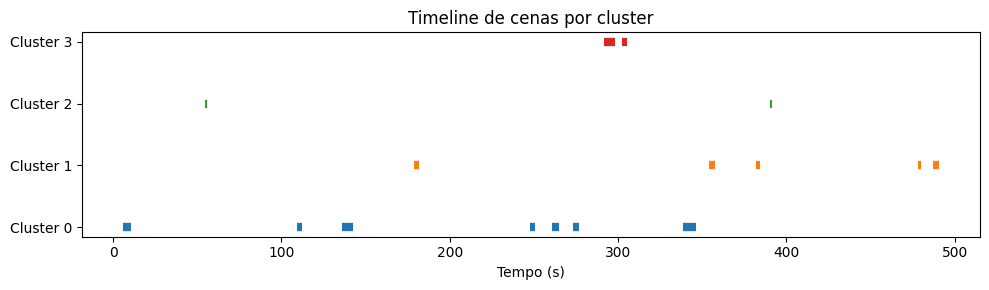

20

In [ ]:
df = clustering(df, video_name, n_clusters=4)
# plot_scatter_pca(df)
# plot_scatter_umap(df)

plot_cluster_timeline(df)

In [176]:
write_top2_cluster_videos(
    df,
    video_file=f"data/{video_file[:-4]}_lowres.mp4",
    output_dir="data/highlight"
)

video path: /home/rafa/Documents/projects/git/cinematic-data-clustering/data/long_lowres.mp4
shot: 0       5.933333
1       7.333333
3     109.066667
4     136.000000
5     139.066667
7     247.733333
8     260.800000
9     273.200000
13    338.800000
14    342.733333
Name: start, dtype: float64


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Vídeo cluster 0 salvo em: /home/rafa/Documents/projects/git/cinematic-data-clustering/data/highlight/data_cluster_0.mp4
shot: 6     178.666667
15    353.866667
16    382.200000
18    478.200000
19    487.266667
Name: start, dtype: float64
Vídeo cluster 1 salvo em: /home/rafa/Documents/projects/git/cinematic-data-clustering/data/highlight/data_cluster_1.mp4


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e